# COVID-19 Data Science Mini Project
## Objective: Predict ICU Admission Using Patient Data
This notebook follows the data science lifecycle to analyze a COVID-19 dataset, including data cleaning, exploration, modeling, and visualization.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Load and clean data
df = pd.read_csv('../data/Covid_data.csv')


# Check missing values and duplicates
print("Missing values:\n", df.isnull().sum())
print("Number of duplicates:", df.duplicated().sum())

# Handle missing values (precautionary, based on prior output showing no NAs)
df['DATE_DIED'] = df['DATE_DIED'].fillna('Alive')

# Drop duplicates
df = df.drop_duplicates()

# Verify cleaning
print("Cleaned dataset info:\n", df.info())

Missing values:
 USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64
Number of duplicates: 812049
<class 'pandas.core.frame.DataFrame'>
Index: 236526 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   USMER                 236526 non-null  int64 
 1   MEDICAL_UNIT          236526 non-null  int64 
 2   SEX                   236526 non-null  int64 
 3   PATIENT_TYPE          236526

Dataset Summary:
                USMER   MEDICAL_UNIT            SEX   PATIENT_TYPE  \
count  236526.000000  236526.000000  236526.000000  236526.000000   
mean        1.512337       7.634230       1.547521       1.577712   
std         0.499849       3.661318       0.497738       0.493925   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       4.000000       1.000000       1.000000   
50%         2.000000       6.000000       2.000000       2.000000   
75%         2.000000      12.000000       2.000000       2.000000   
max         2.000000      13.000000       2.000000       2.000000   

             INTUBED      PNEUMONIA            AGE       PREGNANT  \
count  236526.000000  236526.000000  236526.000000  236526.000000   
mean       44.238401       4.525765      52.620274      54.794826   
std        47.394072      16.731469      19.318869      47.225449   
min         1.000000       1.000000       0.000000       1.000000   
25%         2.0

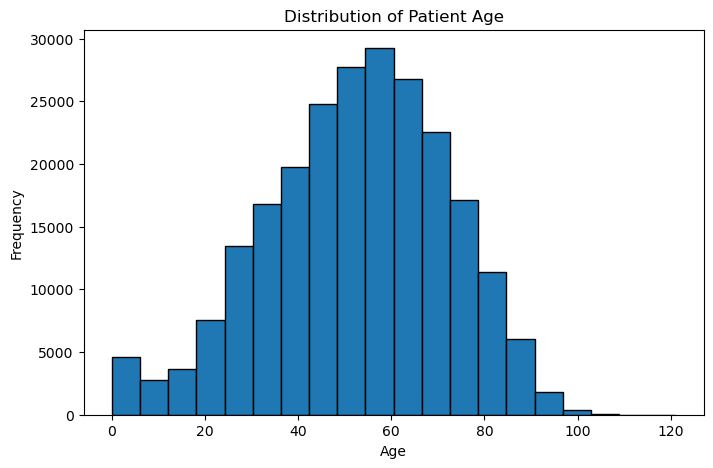

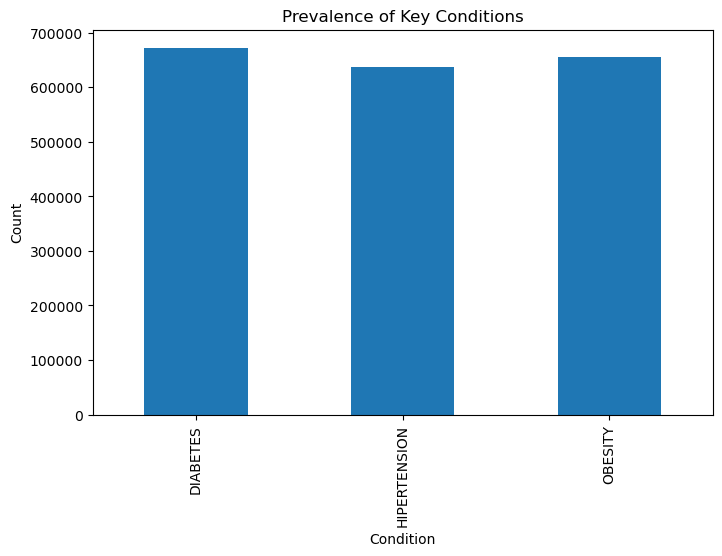

In [6]:
# Exploratory Data Analysis (EDA) - Distribution
print("Dataset Summary:\n", df.describe())

# Age distribution
plt.figure(figsize=(8, 5))
plt.hist(df['AGE'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('../outputs_with_randomForest/age_distribution.png')
plt.show()

# Condition prevalence
condition_counts = df[['DIABETES', 'HIPERTENSION', 'OBESITY']].sum()
condition_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Prevalence of Key Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.savefig('../outputs_with_randomForest/condition_prevalence.png')
plt.show()

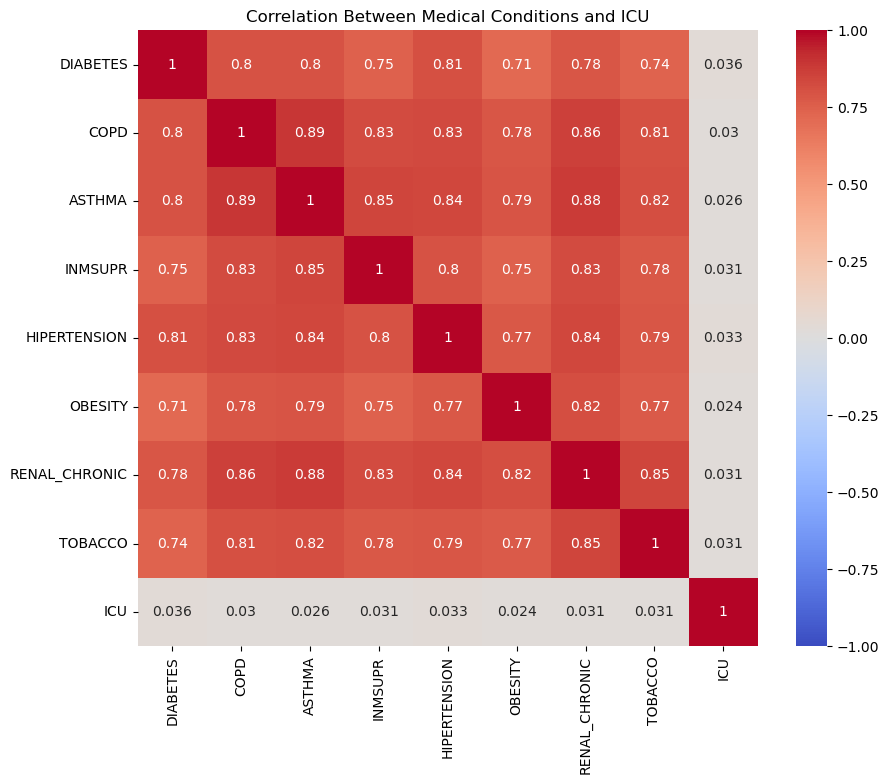

In [7]:
# EDA - Correlation Analysis
binary_cols = ['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']
for col in binary_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

correlation_matrix = df[binary_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Medical Conditions and ICU')
plt.savefig('../outputs_with_randomForest/correlation_heatmap.png')
plt.show()

In [8]:
# Feature Engineering
def categorize_age(age):
    if age <= 30: return '0-30'
    elif age <= 60: return '31-60'
    else: return '61+'

df['AGE_GROUP'] = df['AGE'].apply(categorize_age)
chronic_conditions = ['DIABETES', 'COPD', 'ASTHMA', 'HIPERTENSION', 'OBESITY', 'RENAL_CHRONIC']
df['CHRONIC_ILLNESS'] = df[chronic_conditions].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Verify new features
print(df[['AGE', 'AGE_GROUP', 'CHRONIC_ILLNESS']].head())

   AGE AGE_GROUP  CHRONIC_ILLNESS
0   65       61+                1
1   72       61+                1
2   55     31-60                1
3   53     31-60                1
4   68       61+                1


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22904\4250428824.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('ICU_BINARY', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))


RandomizedSearch took 9.604579448699951 seconds
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Accuracy on Subset: 0.6267962806424345
Subset Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.63      0.76      2209
           1       0.10      0.59      0.17       157

    accuracy                           0.63      2366
   macro avg       0.53      0.61      0.47      2366
weighted avg       0.90      0.63      0.72      2366

Accuracy on Full Dataset: 0.6402763332572318
Full Dataset Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.64      0.77    221143
           1       0.11      0.60      0.18     15383

    accuracy                           0.64    236526
   macro avg       0.53      0.62      0.47    236526
weighted avg       0.90      0.64      0.73    236526

Feature Importance:
           Feature  I

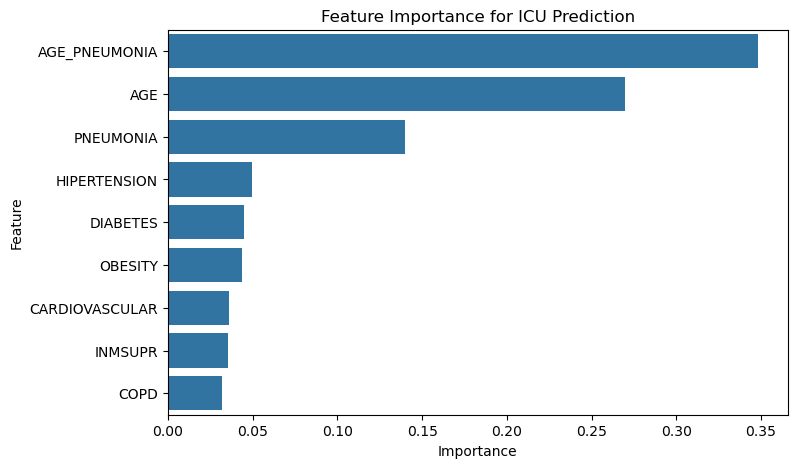

AUC-ROC Score: 0.6571898977258638


In [9]:
# Prepare and validate data model
# Convert ICU to binary (1 = ICU, others = non-ICU)
df['ICU_BINARY'] = df['ICU'].apply(lambda x: 1 if x == 1 else 0)

# Feature engineering: Add interaction term to the original df
df['AGE_PNEUMONIA'] = df['AGE'] * df['PNEUMONIA']

# Stratified downsampling to preserve class distribution (5% of each class)
df_sampled = df.groupby('ICU_BINARY', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))

# Features and target
features = ['AGE', 'PNEUMONIA', 'DIABETES', 'COPD', 'HIPERTENSION', 'OBESITY', 'INMSUPR', 'AGE_PNEUMONIA', 'CARDIOVASCULAR']
X = df_sampled[features]
y = df_sampled['ICU_BINARY']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle imbalance with SMOTE (increased sampling)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train Random Forest with RandomizedSearchCV and enhanced parameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10}, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train_res, y_train_res)
print(f"RandomizedSearch took {time.time() - start_time} seconds")

# Best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Prepare full dataset for evaluation
X_full = df[features]
y_full = df['ICU_BINARY']
y_full_pred = best_model.predict(X_full)

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("Accuracy on Subset:", accuracy_score(y_test, y_pred))
print("Subset Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy on Full Dataset:", accuracy_score(y_full, y_full_pred))
print("Full Dataset Classification Report:\n", classification_report(y_full, y_full_pred))

# Feature importance
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

# Visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for ICU Prediction')
plt.savefig('../outputs_with_randomForest/feature_importance.png')
plt.show()

# Additional metric: AUC-ROC
from sklearn.metrics import roc_auc_score
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_prob))

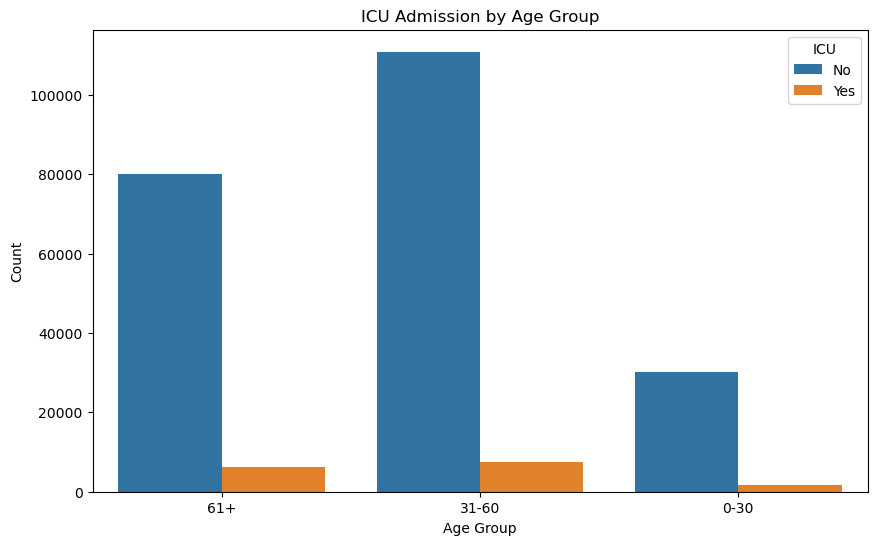

In [10]:
# Additional Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='AGE_GROUP', hue='ICU_BINARY', data=df)
plt.title('ICU Admission by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='ICU', labels=['No', 'Yes'])
plt.savefig('../outputs_with_randomForest/icu_by_age.png')
plt.show()

In [11]:
df.to_csv('../data/processed_covid_data.csv', index=False)
print("Processed dataset saved to ../data/processed_covid_data.csv")

Processed dataset saved to ../data/processed_covid_data.csv


In [12]:
feature_importance.to_csv('../outputs_with_randomForest/feature_importance_rf.csv', index=False)
print("Random Forest feature importance saved to ../outputs_with_randomForest/feature_importance_rf.csv")

Random Forest feature importance saved to ../outputs_with_randomForest/feature_importance_rf.csv
